# Klasifikasi 13 Emosi Pada Twitter

**Anggota:**
1. Puteri Aulia Indrasti	 - 165150201111158
2. Meutya Choirunnisa		 - 165150201111258
3. Rhayhana Putri Justitia	 - 165150201111270
4. Elva Christiana Themin	 - 165150201111264

## import library

In [4]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import seaborn as sns
from textblob import TextBlob
from sklearn.feature_extraction.text import CountVectorizer
import re
from Sastrawi.Stemmer.StemmerFactory import StemmerFactory
from nltk.tokenize import word_tokenize
from nltk.tokenize import sent_tokenize
import nltk
from nltk import sent_tokenize, word_tokenize
from nltk.stem import PorterStemmer 
from nltk.corpus import stopwords


import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style('whitegrid')
%matplotlib inline
from plotly.offline import download_plotlyjs, init_notebook_mode, plot, iplot
init_notebook_mode(connected=True)
import plotly.graph_objs as go

import findspark
findspark.init()

findspark.find()
import pyspark
from pyspark.sql import SparkSession
from pyspark.sql.types import FloatType
import pyspark.sql.functions as f

## read data

In [69]:
data = pd.read_csv('text_emotion.csv')

In [70]:
print("data shape = ", data.shape)

data shape =  (10601, 4)


In [71]:
data.head()

,tweet_id,sentiment,author,content
0,1.956967e+09,empty,xoshayzers,@tiffanylue i know i was listenin to bad habi...
1,1.956968e+09,sadness,wannamama,Layin n bed with a headache ughhhh...waitin o...
2,1.956968e+09,sadness,coolfunky,Funeral ceremony...gloomy friday...
3,1.956968e+09,enthusiasm,czareaquino,wants to hang out with friends SOON!
4,1.956968e+09,neutral,xkilljoyx,@dannycastillo We want to trade with someone w...


In [72]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10601 entries, 0 to 10600
Data columns (total 4 columns):
tweet_id     500 non-null float64
sentiment    500 non-null object
author       500 non-null object
content      500 non-null object
dtypes: float64(1), object(3)
memory usage: 331.4+ KB


## data value counts

In [73]:
data['sentiment'].value_counts()
#random 1300

worry         139
sadness       124
neutral       120
hate           33
surprise       20
happiness      14
empty          13
love           12
fun             9
relief          6
enthusiasm      5
boredom         4
anger           1
Name: sentiment, dtype: int64

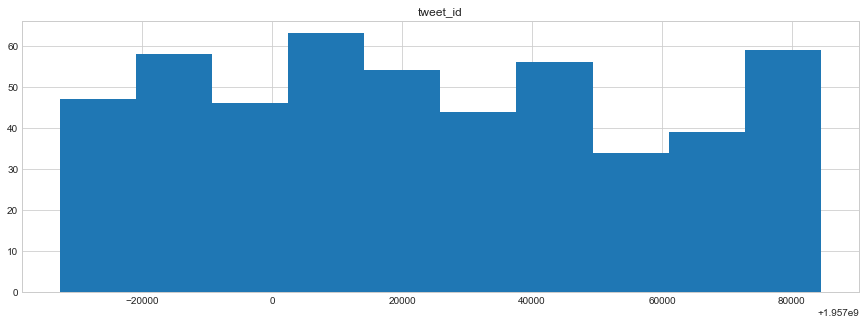

In [74]:
data.hist(figsize=(15,5));

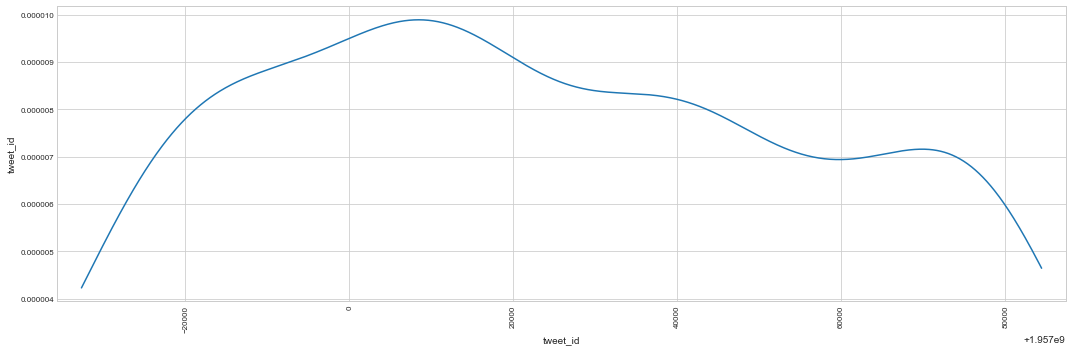

In [75]:
pd.plotting.scatter_matrix(data, alpha=1, figsize=(15,5), diagonal='kde');
plt.tight_layout()

## Spark

In [99]:
spark = SparkSession.builder.appName('spark-tweet').getOrCreate()
df = spark.read.format("csv").option("header", "true").option("mode", "DROPMALFORMED").load("emotion30.csv")
df.show(5)

+----------+---------+---------------+--------------------+
|  tweet_id|sentiment|         author|             content|
+----------+---------+---------------+--------------------+
|1957083641|    anger|       elDi_irk|fuckin'm transtel...|
|1957089935|    anger|          umi78|Working   But it'...|
|1957110088|    anger|      NayNay_Rt|Packing  I don't ...|
|1957289252|    anger|     crazy_erin|I tried to dye my...|
|1957291305|    anger|msfussybritches|&quot;locked up a...|
+----------+---------+---------------+--------------------+
only showing top 5 rows



In [100]:
df.printSchema()

root
 |-- tweet_id: string (nullable = true)
 |-- sentiment: string (nullable = true)
 |-- author: string (nullable = true)
 |-- content: string (nullable = true)



In [101]:
from pyspark.sql.functions import col
df.groupBy("sentiment") \
    .count() \
    .orderBy(col("count").desc()) \
    .show()

+----------+-----+
| sentiment|count|
+----------+-----+
|      love|   31|
|      hate|   31|
|   neutral|   31|
|    relief|   31|
| happiness|   31|
|  surprise|   31|
|     worry|   31|
|enthusiasm|   31|
|   sadness|   31|
|       fun|   31|
|     empty|   31|
|   boredom|   30|
|     anger|   30|
+----------+-----+



In [102]:
df.groupBy("content") \
    .count() \
    .orderBy(col("count").desc()) \
    .show()

+--------------------+-----+
|             content|count|
+--------------------+-----+
|My stomach is all...|    1|
|@BrodyJenner if u...|    1|
|How are YOU convi...|    1|
|     i want candy!!!|    1|
|@katieclair88 You...|    1|
|so tired and i th...|    1|
|@raaaaaaek oh too...|    1|
| I want another tatt|    1|
|Counting the minu...|    1|
|@Dancing_Monk Nei...|    1|
|is really, really...|    1|
|Wow, been away 4 ...|    1|
|@Jukie_08 hell ye...|    1|
|Layin n bed with ...|    1|
|just picked up he...|    1|
|Last Chemistry le...|    1|
|@DymeDiva23 Nite....|    1|
|...and all woman ...|    1|
|Bitten to blood b...|    1|
|Just discovered a...|    1|
+--------------------+-----+
only showing top 20 rows



In [103]:
from pyspark.ml.feature import RegexTokenizer, StopWordsRemover, CountVectorizer
from pyspark.ml.classification import LogisticRegression
# regular expression tokenizer
regexTokenizer = RegexTokenizer(inputCol="content", outputCol="words", pattern="\\W")
# stop words
add_stopwords = ["http","https","amp","rt","t","c","the"] 
stopwordsRemover = StopWordsRemover(inputCol="words", outputCol="filtered").setStopWords(add_stopwords)
# bag of words count
countVectors = CountVectorizer(inputCol="filtered", outputCol="features", vocabSize=10000, minDF=5)

In [ ]:
from pyspark.ml import Pipeline
from pyspark.ml.feature import OneHotEncoder, StringIndexer, VectorAssembler
label_stringIdx = StringIndexer(inputCol = "sentiment", outputCol = "label")
pipeline = Pipeline(stages=[regexTokenizer, stopwordsRemover, countVectors, label_stringIdx])
# Fit the pipeline to training documents.
pipelineFit = pipeline.fit(df)
dataset = pipelineFit.transform(df)
dataset.show(5)

In [ ]:
from pyspark.ml.feature import HashingTF, IDF
hashingTF = HashingTF(inputCol="filtered", outputCol="rawFeatures", numFeatures=10000)
idf = IDF(inputCol="rawFeatures", outputCol="features", minDocFreq=5) #minDocFreq: remove sparse terms
pipeline = Pipeline(stages=[regexTokenizer, stopwordsRemover, hashingTF, idf, label_stringIdx])
pipelineFit = pipeline.fit(df)
dataset = pipelineFit.transform(df)
(trainingData, testData) = dataset.randomSplit([0.7, 0.3], seed = 100)

In [97]:
df.rdd.take(5)

[Row(0='#3wordsaftersex it never started...', empty='neutral'),
 Row(0='#thingsmummysaid my mummy told me she never wnted to be my mummy ever again  so i live wid my dad i think ?? it all confusing', empty='anger'),
 Row(0="#thingsmummysaid You need to learn to wash dishes and do laundry because I won't always be here to do them for you. She was right", empty='relief'),
 Row(0='#twitterfails fucking hard right now...this is annoying', empty='anger'),
 Row(0="$#@! My nose stud fell out and I can't find it  Looks like I'll have to head into Amsterdam today and get a new one", empty='worry')]

In [98]:
rddata = df.rdd.map(lambda col: np.array(col[0:]))
rddata.take(5)

[array(['#3wordsaftersex it never started...', 'neutral'], dtype='<U35'),
 array(['#thingsmummysaid my mummy told me she never wnted to be my mummy ever again  so i live wid my dad i think ?? it all confusing',
        'anger'], dtype='<U125'),
 array(["#thingsmummysaid You need to learn to wash dishes and do laundry because I won't always be here to do them for you. She was right",
        'relief'], dtype='<U129'),
 array(['#twitterfails fucking hard right now...this is annoying', 'anger'],
       dtype='<U55'),
 array(["$#@! My nose stud fell out and I can't find it  Looks like I'll have to head into Amsterdam today and get a new one",
        'worry'], dtype='<U115')]

In [118]:
rdd3 = rddata.groupByKey()
rdd3.take(5)

[('#3wordsaftersex it never started...',
  <pyspark.resultiterable.ResultIterable at 0x2061f1a6ac8>),
 ('#thingsmummysaid my mummy told me she never wnted to be my mummy ever again  so i live wid my dad i think ?? it all confusing',
  <pyspark.resultiterable.ResultIterable at 0x2061f1a6a90>),
 ("#thingsmummysaid You need to learn to wash dishes and do laundry because I won't always be here to do them for you. She was right",
  <pyspark.resultiterable.ResultIterable at 0x2061f1a6c50>),
 ('#twitterfails fucking hard right now...this is annoying',
  <pyspark.resultiterable.ResultIterable at 0x2061f1a69e8>),
 ("$#@! My nose stud fell out and I can't find it  Looks like I'll have to head into Amsterdam today and get a new one",
  <pyspark.resultiterable.ResultIterable at 0x2061f1a6cf8>)]

In [24]:
from sklearn.model_selection import KFold
x = np.array([[1,2],[3,4],[1,2],[3,4]])
# y = np.array([1,2,3,4])
kf = KFold(n_splits=3)
kf.get_n_splits(x)

for train, test in kf.split(x):
    print(train)
#     print(test)
xtrain, xtest = x[train], x[test]
ytrain, ytest = y[train], y[test]
print(ytrain)

[2 3]
[0 1 3]
[0 1 2]
[1 2 3]


# Using Spark

In [ ]:
import csv
import re
import numpy
import math
from Sastrawi.Stemmer.StemmerFactory import StemmerFactory
from Sastrawi.StopWordRemover.StopWordRemoverFactory import StopWordRemoverFactory
from nltk.stem import PorterStemmer 
from multiprocessing.pool import ThreadPool
import findspark
findspark.init()

findspark.find()
import pyspark

from pyspark.sql import SparkSession

class klasifikasi():
    def __init__(self):
        a = input("query : ")
        spark = SparkSession.builder.appName('twitter-knn-2').getOrCreate()
        self.data_uji = {}
        self.data_training = {}
        self.hasil_preprocessing_latih = {}
        self.hasil_preprocessing_uji = {}
        with open('emotion1300.csv',  errors='ignore') as csvread_training:
            readCSV = csv.reader(csvread_training, delimiter=',')
            a = 0
            for row in readCSV:
                self.data_training.update({"latih"+str(a):row})
                a+=1
        #print (self.data_training)
        for data in self.data_training:
            self.hasil_preprocessing_latih.update({data:self.preprocessing(self.data_training[data][0])})
        self.term = self.getTerm(self.hasil_preprocessing_latih)
        self.tf = self.hitung_tf(self.term, self.hasil_preprocessing_latih)
        self.wtf = self.hitung_wtf(self.tf)
        self.idf = self.hitung_idf(self.tf)
        self.wtd = self.hitung_wtd(self.wtf, self.idf)
        self.norm = self.normalisasi(self.wtd)
        
        with open('test.csv', errors='ignore') as csvread_uji:
            readCSV_uji = csv.reader(csvread_uji, delimiter=',')
            b=0
            for row in readCSV_uji:
                
                self.data_uji.update({"uji"+str(b):row})
                b+=1
        for data_uji in self.data_uji:
            self.hasil_preprocessing_uji.update({data_uji:self.preprocessing(self.data_uji[data_uji][0])})
        self.tf_uji = self.hitung_tf(self.term, self.hasil_preprocessing_uji)
        self.wtf_uji = self.hitung_wtf(self.tf_uji)
        self.wtd_uji = self.hitung_wtd(self.wtf_uji, self.idf)
        self.norm_uji = self.normalisasi(self.wtd_uji)
#        print (self.wtd_uji)
#        print(self.data_training)
        self.cosine_sim()
        self.knn()
        
        
    def preprocessing(self,teks):
        klm = teks.lower()
        klm = re.sub(r"\W|\d"," ",klm) #membersihkan tanda baca
        klm = re.sub(r"\s+"," ", klm)
        klm = klm.strip("\s")
        klm = self.removeStopword(klm)
        klm = self.stemming(klm)
        klm = self.tokenizing(klm)
        print(klm)
        return klm
    
    #split kata berdasarkan spasi
    def tokenizing(self, teks):
        return re.split("\s",teks)
    
    #ngapus kata yg ada di library stopword
    def removeStopword(self,teks):
        fac = StopWordRemoverFactory()
        remove = fac.create_stop_word_remover()
        return remove.remove(teks)
    
    #jadiin kata dasar
    def stemming(self,teks):
        factory = PorterStemmer()
        stemmer = factory.stem(teks)
        return stemmer
    
    #untuk nyimpan hasil pre processing
    def getTerm(self, hasil_preprocessing):
        term = []
        for doc in hasil_preprocessing:
            for kata in hasil_preprocessing[doc]:
                if kata not in term:
                    term.append(kata)
        print(term)
        return term
    
    #ngitung term frequency
    def hitung_tf(self, term, hasil_preprocessing):
        tf = {}
        for kata in term:
            freq = {}
            for doc in hasil_preprocessing:
                freq.update({doc:self.getFreq(kata,hasil_preprocessing[doc])})
            tf.update({kata:freq})
#        print(tf)
        return tf
    
    #
    def getFreq(self, kata, dok):
        jml = 0
        for t in dok:
            if kata == t:
                jml+=1
        return jml
    
    #log frequency yg 1 + log 10 tf
    def hitung_wtf(self, termf):
        wtf = {}
        for kata in termf:
            a = {}
            for dok in termf[kata]:
                if termf[kata][dok]>0:
                    #ngitung wtf
                    a.update({dok:1+numpy.log10(termf[kata][dok])})
                else :
                    #kalo nilai tf = 0
                    a.update({dok:0})
            wtf.update({kata:a})
        return wtf
    
    #ngitung df dulu, baru idf
    def hitung_idf(self,termf):
        idf = {}
        for kata in termf:
            df = 0
            n = len(termf[kata])
            for dok in termf[kata]:
                if termf[kata][dok]>0:
                    df +=1
            idf.update({kata:numpy.log10(n/df)})
        return idf
    
    #ngitung tf-idf
    def hitung_wtd(self,wtf,idf):
        wtd = {}
        for kata in wtf:
            a = {}
            for doc in wtf[kata]:
                a.update({doc:wtf[kata][doc]*idf[kata]})
            wtd.update({kata:a})
        return wtd


    def normalisasi(self,wtd):
        penyebut = {}
        for dok in wtd[self.term[0]]:
            x = 0
            for kata in wtd:
                x += wtd[kata][dok] ** 2
            penyebut.update({dok:math.sqrt(x)})
        normalisasi = {}
        for kata in wtd:
            y = {}
            for dok in wtd[kata]:
                y.update({dok:wtd[kata][dok]/penyebut[dok]})
            normalisasi.update({kata:y})
        return normalisasi
        
        
    def cosine_sim(self):
        #membagi perhitungan menjadi beberapa thread
        pool = ThreadPool(len(self.data_uji))
        parameters = range(len(self.data_uji))
        hasil = pool.map(lambda n: self.calculate(), parameters)
#         rdd1 = spark.sparkContext.parallelize(hasil, len(hasil))
#         detail_hasil = rddata.reduceByKey(lambda n: self.calculate(), parameters)    
#         hasil_cosine = detail_hasil.map(lambda x: detail_hasil).collect()
        return hasil

    def calculate(self):
        self.cosim = {}
        for dok_uji in self.data_uji:
            cos = {}
            for dok_latih in self.data_training:
                sum = 0
                for kata in self.term:
                    sum += self.norm[kata][dok_latih]*self.norm_uji[kata][dok_uji]
                #nyari cosine distance = 1 - cosim
                cos.update({dok_latih:1-sum})
            cos_sort = sorted(cos, key=cos.get, reverse=False)
            self.cosim.update({dok_uji:cos_sort})
        print(cos_sort)
            
    def knn(self):
        for k in range(2,11):
            hasil_klasifikasi = {}
            jml_benar = 0
            for dok_uji in self.data_uji:
                i = 0
                kelas_0 = 0
                kelas_1 = 0
                kelas_2 = 0
                kelas_3 = 0
                kelas_4 = 0
                kelas_5 = 0
                kelas_6 = 0
                kelas_7 = 0
                kelas_8 = 0
                kelas_9 = 0
                kelas_10 = 0
                kelas_11 = 0
                kelas_12 = 0
                for cosim in self.cosim[dok_uji]:
                    if i<k:
                        if self.data_training[cosim][1] == "anger":
                            kelas_0 +=1
                        elif self.data_training[cosim][1] == "boredom":
                            kelas_1 += 1
                        elif self.data_training[cosim][1] == "empty":
                            kelas_2 += 1
                        elif self.data_training[cosim][1] == "enthusiasm":
                            kelas_3 += 1
                        elif self.data_training[cosim][1] == "fun":
                            kelas_4 += 1
                        elif self.data_training[cosim][1] == "happiness":
                            kelas_5 += 1
                        elif self.data_training[cosim][1] == "hate":
                            kelas_6 += 1
                        elif self.data_training[cosim][1] == "love":
                            kelas_7 += 1
                        elif self.data_training[cosim][1] == "neutral":
                            kelas_8 += 1
                        elif self.data_training[cosim][1] == "relief":
                            kelas_9 += 1
                        elif self.data_training[cosim][1] == "sadness":
                            kelas_10 += 1
                        elif self.data_training[cosim][1] == "surprise":
                            kelas_11 += 1
                        elif self.data_training[cosim][1] == "worry":
                            kelas_12 += 1
                    i+=1
                kelas = self.maksimal(kelas_0,kelas_1,kelas_2,kelas_3, kelas_4, kelas_5, kelas_6, kelas_7, kelas_8, kelas_9, kelas_10, kelas_11, kelas_12)
                if self.data_uji[dok_uji][1]==kelas:
                    jml_benar += 1
                hasil_klasifikasi.update({dok_uji:kelas})
            print (hasil_klasifikasi)
            print ("k: "+str(k) +" akurasi: "+str(jml_benar/len(self.data_uji)*100))
    
    #untuk nyari dia itu paling banyak muncul di kelas yg mana
    def maksimal(self, kelas_0, kelas_1, kelas_2, kelas_3, kelas_4, kelas_5, kelas_6, kelas_7, kelas_8, kelas_9, kelas_10, kelas_11, kelas_12):
        kelas = {"anger":kelas_0,"boredom":kelas_1,"empty":kelas_2,"enthusiasm":kelas_3,"fun":kelas_4,"happiness":kelas_5, "hate":kelas_6, "love":kelas_7,"neutral":kelas_8,"relief":kelas_9,"sadness":kelas_10,"surprise":kelas_11,"worry":kelas_12}
        maks = 0; maks_kelas = "";
        for k in kelas:
            if kelas[k] > maks:
                maks = kelas[k]
                maks_kelas = k
                #print(maks_kelas)
        return maks_kelas
    
klas = klasifikasi()

query : l
['', '']
['', 'wordsaftersex', 'it', 'never', 'started', '']
['', 'thingsmummysaid', 'my', 'mummy', 'told', 'me', 'she', 'never', 'wnted', 'to', 'be', 'my', 'mummy', 'ever', 'again', 'so', 'i', 'live', 'wid', 'my', 'dad', 'i', 'think', 'it', 'all', 'confus']
['', 'thingsmummysaid', 'you', 'need', 'to', 'learn', 'to', 'wash', 'dishes', 'and', 'do', 'laundry', 'because', 'i', 'won', 't', 'always', 'be', 'here', 'to', 'do', 'them', 'for', 'you', 'she', 'was', 'right']
['', 'twitterfails', 'fucking', 'hard', 'right', 'now', 'this', 'is', 'annoy']
['', 'my', 'nose', 'stud', 'fell', 'out', 'and', 'i', 'can', 't', 'find', 'it', 'looks', 'like', 'i', 'll', 'have', 'to', 'head', 'into', 'amsterdam', 'today', 'and', 'get', 'a', 'new', 'on']
['', 'quot', 'not', 'academically', 'of', 'course', 'quot', 'i', 'miss', 'him', 'alreadi']
['', 'quot', 'locked', 'up', 'abroad', 'quot', 'makes', 'bein', 'half', 'brown', 'good', 'risk', 'mgmt', 'when', 'travelin', 'rd', 'world', 'i', 'blend', 'i',

['losing', 'makeup', 'bags', 'is', 'tragic', 'luckily', 'i', 'keep', 'in', 'diff', 'places', 'but', 'i', 'gotta', 'replace', 'my', 'bare', 'escentuals', 'tearrrrrrrr', '']
['lost', 'all', 'my', 'files', 'since', 'high', 'school', '']
['lots', 'of', 'confusions', 'i', 've', 'at', 'my', 'work', 'place', '']
['lyin', 'in', 'bed', 'up', 'faaaaar', 'too', 'earli']
['man', 'i', 'am', 'being', 'boring', 'today', 'not', 'tweeting', 'how', 'are', 'you', 'guys', '']
['mannnn', 'alllyy_', 'got', 'an', 'iphone', 'im', 'jealous', '']
['math', 'quiz', 'if', 'meow', 'but', 'allergies', 'then', 'meow', 'allergies', '']
['miss', 'th']
['missed', 'all', 'the', 'awesome', 'weather', 'because', 'she', 'was', 'in', 'a', 'movie', '']
['mmm', 'much', 'better', 'day', 'so', 'far', 'it', 's', 'still', 'quite', 'early', 'last', 'day', 'of', 'ud']
['moment', 'of', 'truth', 'im', 'nervous', 'for', 'her', '']
['monday', 'funday', 'wake', 'up', 'people', 'and', 'keep', 'me', 'awake', 'please', 'today', 'is', 'going

['', 'cha_rade', 'no', 'the', 'economy', 'gotcha', 'sorry', 'but', 'so', 'happy', 'that', 'you', 'got', 'another', 'one', 'in', 'la', 'enjoy', 'socal', 'ahahaay', 'lol']
['', 'chantiparnell', 'i', 'wana', 'be', 'there', 'num', 'fan', 'sharsies', '']
['', 'charlieboy', 'thanks', 'for', 'the', 'rt', 'and', 'sorry', 'about', 'your', 'new', 'place', 'with', 'the', 'domest']
['', 'charviray', 'charlene', 'my', 'love', 'i', 'miss', 'y']
['', 'cheri', 'two', 'macaroons', 'go', 'into', 'a', 'bar', 'one', 'says', 'your', 'a', 'nut', 'wow', 'i', 'need', 'to', 'get', 'out', 'more', '']
['', 'cayogial', 'i', 'wanted', 'to', 'come', 'to', 'bz', 'this', 'summer', 'not', 'so', 'sure', 'anymore', 'a', 'teacher', 's', 'life', 'in', 'the', 'summer', 'suck']
['', 'celldweller', 'must', 'have', 'new', 'music', 'i', 'won', 't', 'sleep', 'until', 'you', 'give', 'us', 'chapter', 'i', 'might', 'die', 'first', 'though', 'hurry', '']
